In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Conv2DTranspose, Reshape
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

del y_train, y_test

In [0]:
def create_encoder(img_shape, code_size):
  encoder = Sequential()
  encoder.add(Conv2D(32, (3, 3), padding='same', activation='elu', input_shape=img_shape))
  encoder.add(MaxPool2D())
  encoder.add(Conv2D(64, (3, 3), padding='same', activation='elu'))
  encoder.add(MaxPool2D())
  encoder.add(Conv2D(128, (3, 3), padding='same', activation='elu'))
  encoder.add(MaxPool2D())
  encoder.add(Conv2D(256, (3, 3), padding='same', activation='elu'))
  encoder.add(MaxPool2D())
  encoder.add(Flatten())
  encoder.add(Dense(code_size))
  
  return encoder

def create_decoder(img_shape, code_size):
  decoder = Sequential()
  decoder.add(Dense(np.prod(img_shape), input_shape=(code_size, )))
  decoder.add(Reshape(img_shape))
  decoder.add(Conv2DTranspose(128, (3, 3), padding='same', activation='elu'))
  decoder.add(Conv2DTranspose(64, (3, 3), padding='same', activation='elu'))
  decoder.add(Conv2DTranspose(32, (3, 3), padding='same', activation='elu'))  
  decoder.add(Conv2DTranspose(1, (3, 3), padding='same', activation=None))
  
  return decoder

In [0]:
def add_noise(X, sigma=0.1):
  noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
  return X + noise

X_train_noise = add_noise(X_train, 0.1)
X_test_noise = add_noise(X_test, 0.1)

In [5]:
img_shape = (28, 28, 1)
encoder = create_encoder(img_shape, 512)
decoder = create_decoder(img_shape, 512)


inputs = Input(img_shape)

code = encoder(inputs)
reconstruction = decoder(code)

denoise_autoencoder = Model(inputs=inputs, outputs=reconstruction)
denoise_autoencoder.compile(loss='mse', optimizer='adamax')
denoise_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 512)               519424    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         496017    
Total params: 1,015,441
Trainable params: 1,015,441
Non-trainable params: 0
_________________________________________________________________


In [6]:
denoise_autoencoder.fit(X_train_noise, X_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0116
Epoch 2/5
 9568/60000 [===>..........................] - ETA: 56s - loss: 0.0054

60000/60000 [==============================] - 67s 1ms/step - loss: 0.0048
Epoch 3/5
18464/60000 [========>.....................] - ETA: 46s - loss: 0.0040

60000/60000 [==============================] - 67s 1ms/step - loss: 0.0038
Epoch 4/5
22432/60000 [==========>...................] - ETA: 42s - loss: 0.0034

60000/60000 [==============================] - 67s 1ms/step - loss: 0.0033
Epoch 5/5
24224/60000 [===========>..................] - ETA: 39s - loss: 0.0031

60000/60000 [==============================] - 67s 1ms/step - loss: 0.0030


In [7]:
score = denoise_autoencoder.evaluate(X_test_noise, X_test)
print("MSE Score : ", score)

10000/10000 [==============================] - 3s 329us/step
MSE Score :  0.0029255834121257067


In [0]:
def visualize_results(img, encoder, decoder):
  code = encoder.predict(img[None])[0]
  reconstruction = decoder.predict(code[None])[0]
  
  plt.subplot(1, 3, 1)
  plt.title('Original')
  plt.imshow(img.reshape(28, 28))
  
  plt.subplot(1, 3, 2)
  plt.title('Code')
  plt.imshow(code.reshape([code.shape[-1]//16, -1]))
  
  plt.subplot(1, 3, 3)
  plt.title('Reconstructed')
  plt.imshow(reconstruction.reshape(28, 28))
  
  plt.show()

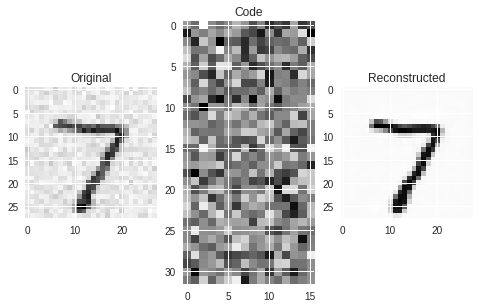

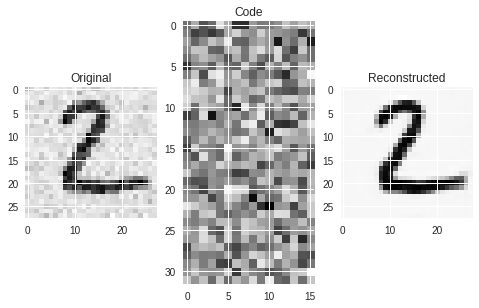

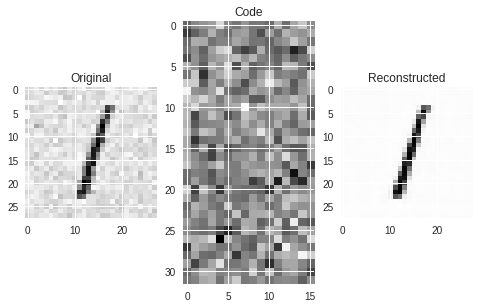

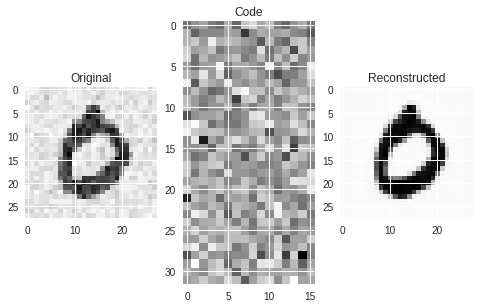

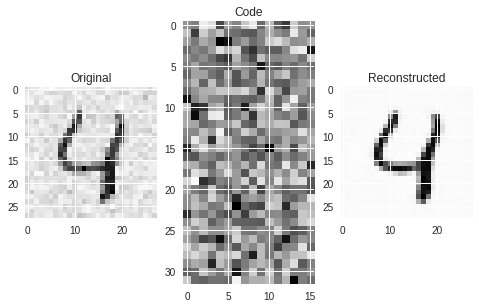

In [9]:
for i in range(5):
  visualize_results(X_test_noise[i], encoder, decoder)